# Домашнее задание №5: "Катастрофическое забывание"

В домашней работе необходимо показать в дейсвии проблему "катастрофического забывания".

**Описание/Пошаговая инструкция выполнения домашнего задания:**
- Проверить качество исходной модели на ImageNette.
- Используя код с лекции дообучить модель решать датасет CIFAR10.
- Вернуть оригинальный последний слой модели и проверить качество на ImageNet.
- Дообучить только последний слой на ImageNette и проверить удалось ли добиться исходного качества.

In [1]:
import random

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torch import optim
import matplotlib.pyplot as plt
from IPython import display

from imagenetlib import get_imagenette_dataloader, ImageNetteDataset

In [2]:
def set_seed(seed=None, seed_torch=True):
    """ Фиксируем генератор случайных чисел
    
    Параметры
    ---------
    seed : int
    seed_torch : bool
      Если True, то будет зафиксирован PyTorch
    """
    
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 1 Проверка качества модели на датасете Imagenette

Воспользуемся функцией get_imagenette_dataloader, которая была сделана в рамках второго домашнего задания.
Функция формирует загрузчик данных на основе датасета Imagenette по ссылке https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz

Документацию по коду можно посмотреть в файле **imagenetlib.py**

В качестве опытной модели возьмем ResNet18 из torchvision. Загрузим предобученную для ImageNet модель, сформируем загрузчик данных для валидации и найдем Accuracy Score для текущей модели.

In [3]:
resnet_model = resnet18(pretrained=True)

In [4]:
IMAGENETTE_DIR = r'D:\Data Science\datasets\imagenette2'

imagenette_val_dataloader = get_imagenette_dataloader(IMAGENETTE_DIR, image_size=224, split='val', batch_size=32,
                                                      std=(0.229, 0.224, 0.225), mean=(0.485, 0.456, 0.406), shuffle=False)

In [5]:
def check_model_accuracy(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    """ Подсчет Accuracy Score для модели
    
    Параметры
    ---------
    model: torch.nn.Module
    dataloader : torch.utils.data.DataLoader
      Загрузчик должен быть сформирован на базе класса imagenetlib.ImageNetteDataset
      
    Результат
    ---------
    accuracy_score : float
    """
    
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    batch_accuracy_list = []
    for batch in tqdm(dataloader):
        batch['image'] = batch['image'].to(device)
        batch_predict = torch.argmax(model(batch['image']), axis=1)
        batch_accuracy = accuracy_score(batch_predict.cpu(), batch['target'])
        batch_accuracy_list.append(batch_accuracy)
        
    return np.mean(batch_accuracy_list)

In [6]:
model_accuracy = check_model_accuracy(resnet_model, imagenette_val_dataloader)
print('Accuracy Score', model_accuracy)

  0%|          | 0/123 [00:00<?, ?it/s]

Accuracy Score 0.7479674796747967


В результате мы получили значение Accuracy Score = 0.748

## 2 Адаптация модели ResNet18 для обучения на датасете CIFAR10 (TransferLearning и Fine-Tuning)

Что требуется сделать:
- сохранить у модели ResNet18 текущий полносвязный слой
- заменить у модели ResNet18 полносвязный слой на новый с выходом размера 10
- заморозить градиент для 80% части модели
- обучить модель на 2 эпохах с частично замороженными градиентами на датасете CIFAR10
- разморозить все слои модели и дообучить ее на 1 эпохе на датасете CIFAR10

### 2.1 Реализация классов для обучения
#### 2.1.1 Реализация класса модели для обучения с помощью PyTorch Lighting

Создадим класс CIFAR10Model для обучения модели.

За основу будет браться модель ResNet18 из torchvision. Модель сохранит полносвязный слой от ImageNet и заменит его совместимым с датасетом CIFAR10.

Реализуем дополнительные методы, которые потребуются нам для проведения экспериментов:
- freeze_layers (заморозка градиента от начала модели вплоть до указанного layer_name без него самого)
- unfreeze_all (разморозка градиентов всей модели)
- set_fc_imagenet (устанавливает в качестве полносвязной сети предварительно сохраненный полносвяный слой для ImageNet)
- set_fc_cifar10 (возвращает для модели полносвязный слой от CIFAR10)

In [7]:
class CIFAR10Model(pl.LightningModule):
    """ Модель для датасета Cifar10
    
    Параметры
    ---------
    model_name : str
      Название модели (должен поддерживать фреймворк timm).
      По умолчанию resnet18
    pretrained : bool
      Если True, то будут загружены веса для предварительно обученной модели
      По умолчанию True.
    learning_rate : float
      Скорость обучения модели. По умолчанию 0.001.
    l2_regularization : float
      Размер L2-регуляризации, по умолчанию 0.01
    adam_betas : tuple
      Коэффициенты для оптимизатора Adam.
      По умолчанию (0.99, 0.999).
    plot_epoch_loss : bool
      Если True, то после каждой эпохи обучения и валидации будет выводиться график с результатами обучения
    seed : int
    """
    def __init__(self, pretrained: bool =True, learning_rate: float = 0.001, 
                 l2_regularization: float = 0.01, adam_betas: (float, float) = (0.99, 0.999), 
                 plot_epoch_loss: bool = True, seed: int = None):
        
        super().__init__()
        
        if seed is not None:
            set_seed(seed)
        
        self._model = resnet18(pretrained=True)
        self._imagenet_fc_layer = self._model.fc
        self._cifar10_fc_layer = nn.Linear(self._imagenet_fc_layer.in_features, 10)
        self._model.fc = self._cifar10_fc_layer
        
        # Устанавливаем тип датасета, требуется для метода _init_opt_parameters
        self.__dataset_type = 'cifar10'
        self._init_opt_parameters()
        
        self.plot_epoch_loss = plot_epoch_loss
        self.learning_rate = learning_rate
        self.l2_regularization = l2_regularization
        self.adam_betas = adam_betas
        
        self.init_train_stats()

        self.save_hyperparameters()
        
    def init_train_stats(self):
        # Словарь для хранения значения ошибок на стадии обучения и валидации
        # Для значений типа train добавляем значение np.nan, так как при первом запуске модель вначале осуществляет
        # шаг валидации без обучения и добавляет значения в списки типа val. Это будет считаться эпохой №0.
        self.train_history = {
            'train_loss': [np.nan],
            'train_acc': [np.nan],
            'val_loss': [],
            'val_acc': [],
        }
        
    def _init_opt_parameters(self):
        """ Инициализируем параметры датасета в зависимости от тип датасета
        
        Изначально модель должна обучаться на cifar10, в этом случае передаем в оптимизатор все параметры.
        Но для эксперимента мы дообучаем модель на ImageNette, в этом случае надо передать в оптимизатор 
        только параметры полносвязной сети.
        
        При смене типов датасетов с помощью методов set_fc_imagenet и set_fc_cifar10
        меняется self.__dataset_type. Поэтому экземпляр класса будет знать,
        для какого датасета ему нужно взять параметры оптимизатора при вызове данного метода
        """
        assert self.__dataset_type in ('cifar10', 'imagenette')
        if self.__dataset_type == 'cifar10':
            self._opt_parameters = self._model.parameters()
        else:
            self._opt_parameters = self._model.fc.parameters()
        
    def freeze_layers(self, layer_name: str):
        """ Заморозка градиента от начала модели 
        вплоть до указанного layer_name без него самого
        
        Параметры
        ---------
        layer_name : str
          Название слоя, вплоть до которого нужно выполнить заморозку
        """
        
        all_layers_names = [name for name, _ in self._model.named_modules()]
        assert layer_name in all_layers_names, "Указанный слой отсутствует в модели"
        
        for param_name, param in self._model.named_parameters():
            if layer_name in param_name:
                break
            param.requires_grad = False
            
        # При изменении параметра requires_grad требуется инициализация 
        # параметров оптимизатора, так как предыдущие параметры исчезают
        self._init_opt_parameters()
            
    def unfreeze_all(self):
        """ Разморозка градиентов всей модели """
        
        for param_name, param in self._model.named_parameters():
            param.requires_grad = True
            
        # При изменении параметра requires_grad требуется инициализация 
        # параметров оптимизатора, так как предыдущие параметры исчезают
        self._init_opt_parameters()
            
    def set_fc_imagenet(self):
        """ Устанавливаем в качестве полносвязной сети
        предварительно сохраненный полносвяный слой ImageNet
        
        Текущий полносвязный слой с его весами для CIFAR10 сохраняется.
        Его можно вернуть через метод set_fc_cifar10()
        """
        self._cifar10_fc_layer = self._model.fc
        self._model.fc = self._imagenet_fc_layer
        
        # Переинициализируем параметры для оптимизатора. Ставим всю модель
        self.__dataset_type = 'imagenette'
        self._init_opt_parameters()
            
    def set_fc_cifar10(self):
        """ Возвращаем для модели полносвязный слой от CIFAR10"""
        
        self._imagenet_fc_layer = self._model.fc
        self._model.fc = self._cifar10_fc_layer
        
        # Переинициализируем параметры для оптимизатора. Ставим только полносвязный слой
        self.__dataset_type = 'cifar10'
        self._init_opt_parameters()
        
    def forward(self, x_in: torch.tensor):
        forward_data = self._model(x_in)
        return forward_data

    def configure_optimizers(self):
        """Конфигурация оптимизатора и планировщика скорости обучения"""
            
        optimizer = optim.AdamW(self._opt_parameters, betas=self.adam_betas, lr=self.learning_rate,
                                weight_decay=self.l2_regularization)
        sheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                  T_0=20,
                                                                  eta_min=1e-4)

        return [optimizer], [sheduler]

    def _share_step(self, batch: dict, batch_idx: int, mode: str = 'train'):
        """ Общий шаг для обучения, валидации и теста
        Параметры
        ---------
        batch : dict
          Батч-словарь в следующем формате:
          {
          'img': список тензоров изображения размером N x C x H x W,
          'image_path': список путей к файлам изображений,
          'target': список целевых значений,
          'parrot_name': список человекочитаемых имен попугаев,
          }
        batch_idx : int
          Номер батча
        mode : str
          Режим. Используется только для префикса названий ошибок в логе.
          По умолчанию train
        """

        # Датасет CIFAR10 генерирует кортежи
        # Датасет ImageNette генерирует словари
        if isinstance(batch, dict):
            batch_images = batch['image']
            target_true = batch['target']
        else:
            batch_images, target_true = batch
            
        target_pred = self(batch_images)

        # Считаем ошибку Binary Cross Entropy и логируем ее
        cross_entropy_loss = F.cross_entropy(target_pred, target_true)
        self.log(f'cross_entropy_{mode}_loss', cross_entropy_loss, prog_bar=True)
        
        acc_loss = accuracy_score(target_true.detach().cpu(), np.argmax(target_pred.detach().cpu(), axis=1).flatten())
        self.log(f'acc_{mode}_loss', acc_loss, prog_bar=True)

        return {'loss': cross_entropy_loss, 'acc_loss': acc_loss}

    def training_step(self, batch: dict, batch_idx: int):
        """Шаг обучения"""
        return self._share_step(batch, batch_idx, mode='train')

    def training_epoch_end(self, outputs: list):
        """Действия после окончания каждой эпохи обучения
        Параметры
        ---------
        outputs : list
          Список словарей. Каждый словарь - результат функции self._share_step для определенного батча на шаге обучения
        """

        # Считаем средние ошибки loss и acc_loss по эпохе
        avg_train_loss = torch.tensor([x['loss'] for x in outputs]).detach().mean()
        avg_acc_loss = torch.tensor([x['acc_loss'] for x in outputs]).detach().mean()

        # Добавляем средние ошибки в словарь статистики обучения, используется для построение графиков
        self.train_history['train_loss'].append(avg_train_loss.numpy().item())
        self.train_history['train_acc'].append(avg_acc_loss.numpy().item())

        # Если включено отображение графика обучения в конце эпохи, то рисуем графики
        if self.plot_epoch_loss:
            self.plot_history_loss()

    def validation_step(self, batch: dict, batch_idx: int):
        """ Шаг валидации """
        return self._share_step(batch, batch_idx, mode='val')

    def validation_epoch_end(self, outputs: list):
        """Действия после окончания каждой эпохи валидации
        Параметры
        ---------
        outputs : list
          Список словарей.
          Каждый словарь - результат функции self._share_step для определенного батча на шаге валидации
        """

        # Считаем средние ошибки loss и rmse_loss по эпохе
        avg_val_loss = torch.tensor([x['loss'] for x in outputs]).detach().mean()
        avg_acc_loss = torch.tensor([x['acc_loss'] for x in outputs]).detach().mean()
        
        # Логируем ошибку валидации
        self.log(f'val_loss', avg_val_loss, prog_bar=True)

        # Добавляем средние ошибки в словарь статистики обучения, используется для построение графиков
        self.train_history['val_loss'].append(avg_val_loss.numpy().item())
        self.train_history['val_acc'].append(avg_acc_loss.numpy().item())

        # Если включено отображение графика обучения в конце эпохи, то рисуем графики
        if self.plot_epoch_loss:
            self.plot_history_loss()

    def plot_history_loss(self, clear_output: bool = True):
        """ Функция построения графика обучения в конце эпохи
        
        Параметры
        clear_output : bool
          Если True, то после каждой эпохи график будет обновляться,
          а не печататься новый.
        """

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].plot(np.arange(0, len(self.train_history['train_loss'])),
                     self.train_history['train_loss'],
                     label="train_loss")
        axes[0].scatter(np.arange(0, len(self.train_history['train_loss'])),
                     self.train_history['train_loss'])
        axes[0].plot(np.arange(0, len(self.train_history['val_loss'])),
                     self.train_history['val_loss'],
                     label="val_loss")
        axes[0].scatter(np.arange(0, len(self.train_history['val_loss'])),
                     self.train_history['val_loss'])
        axes[0].legend(loc='best')
        axes[0].set_xlabel("epochs")
        axes[0].set_ylabel("loss")
        if len(self.train_history['val_loss'])> 1:
            val_loss_epoch_min = np.argmin(self.train_history['val_loss'][1:]) + 1
            val_loss_min = self.train_history['val_loss'][val_loss_epoch_min]
            val_loss_min = round(val_loss_min, 3) if not np.isnan(val_loss_min) else val_loss_min
            title_min_vals = f'\nValidation minimum {val_loss_min} on epoch {val_loss_epoch_min}'
        else:
            title_min_vals = ""
        axes[0].set_title('MODEL LOSS: CROSS ENTROPY'+title_min_vals)
        axes[0].grid()

        axes[1].plot(np.arange(0, len(self.train_history['train_acc'])),
                     self.train_history['train_acc'], label="train_acc")
        axes[1].scatter(np.arange(0, len(self.train_history['train_acc'])),
                     self.train_history['train_acc'])
        axes[1].plot(np.arange(0, len(self.train_history['val_acc'])),
                     self.train_history['val_acc'], label="val_acc")
        axes[1].scatter(np.arange(0, len(self.train_history['val_acc'])),
                     self.train_history['val_acc'])
        axes[1].legend(loc='best')
        axes[1].set_xlabel("epochs")
        axes[1].set_ylabel("accuracy")
        
        if len(self.train_history['val_acc'])> 1:
            val_acc_epoch_max = np.argmax(self.train_history['val_acc'][1:]) + 1
            val_acc_max = self.train_history['val_acc'][val_acc_epoch_max]
            val_acc_max = round(val_acc_max, 3) if not np.isnan(val_acc_max) else val_acc_max
            title_max_vals = f'\nValidation maximum {val_acc_max} on epoch {val_acc_epoch_max}'
        else:
            title_max_vals = ""
        axes[1].set_title('MONITORING LOSS: Accuracy'+title_max_vals)
        axes[1].grid()

        plt.show()
        if clear_output:
            display.clear_output(wait=True)

#### 2.1.2 Реализация загрузчика датасета CIFAR10 PyTorch Lighting

In [8]:
class CIFAR10DataLoader(pl.LightningDataModule):
    """ Загрузчик PyTorch Lighting для датасета CIFAR10
    
    Параметры
    ---------
    train_loader_params : dict
      Словарь для параметров DataLoader обучающего датасета.
      Имеет следующие ключи:
        - batch_size (по умолчанию 16)
        - shuffle (по умолчанию True)
        - num_workers (по умолчанию 2)
        - drop_last (по умолчанию True)
    val_loader_params : dict
      Словарь для параметров DataLoader валидационного датасета.
      Имеет следующие ключи:
        - batch_size (по умолчанию 16)
        - shuffle (по умолчанию False)
        - num_workers (по умолчанию 2)
        - drop_last (по умолчанию False)
    seed : int
      Фиксация генератора случайных чисел.
    """

    def __init__(self, train_loader_params=None, val_loader_params=None, seed=None):

        super().__init__()

        if seed is not None:
            set_seed(seed)

        if not train_loader_params:
            train_loader_params = {
                'batch_size': 16,
                'shuffle': True,
                'num_workers': 2,
                'drop_last': True,
            }

        if not val_loader_params:
            val_loader_params = {
                'batch_size': 16,
                'shuffle': False,
                'num_workers': 2,
                'drop_last': False
            }

        self.train_loader_params = train_loader_params
        self.val_loader_params = val_loader_params
        
        self._transform = T.Compose(
                [T.Resize([224,224]),
                 T.PILToTensor(),
                 T.ConvertImageDtype(torch.float32),
                 T.Normalize(std=(0.229, 0.224, 0.225), mean=(0.485, 0.456, 0.406)),
                ]
        )
        
    def setup(self, stage=None):
        self._cifar_train_dataset = CIFAR10('cifar10/train', train=True, download=True, transform=self._transform)
        self._cifar_val_dataset = CIFAR10('cifar10/val', train=False, download=True, transform=self._transform)

    def train_dataloader(self):
        return DataLoader(self._cifar_train_dataset, batch_size=self.train_loader_params['batch_size'],
                          shuffle=self.train_loader_params['shuffle'], drop_last=self.train_loader_params['drop_last'],
                          num_workers=self.train_loader_params['num_workers'])

    def val_dataloader(self):
        return DataLoader(self._cifar_val_dataset, batch_size=self.val_loader_params['batch_size'],
                          drop_last=self.val_loader_params['drop_last'], shuffle=self.val_loader_params['shuffle'],
                          num_workers=self.val_loader_params['num_workers'])

#### 2.1.3 Реализация загрузчика датасета ImageNette для PyTorch Lighting

In [9]:
class ImageNetteDataLoader(pl.LightningDataModule):
    """ Загрузчик PyTorch Lighting для датасета ImageNette
    
    Параметры
    ---------
    imagenette_path : str
      Путь к папке с датасетом ImageNette
    train_loader_params : dict
      Словарь для параметров DataLoader обучающего датасета.
      Имеет следующие ключи:
        - batch_size (по умолчанию 16)
        - shuffle (по умолчанию True)
        - num_workers (по умолчанию 2)
        - drop_last (по умолчанию True)
    val_loader_params : dict
      Словарь для параметров DataLoader валидационного датасета.
      Имеет следующие ключи:
        - batch_size (по умолчанию 16)
        - shuffle (по умолчанию False)
        - num_workers (по умолчанию 2)
        - drop_last (по умолчанию False)
    seed : int
      Фиксация генератора случайных чисел.
    """

    def __init__(self, imagenette_path, train_loader_params=None, val_loader_params=None, seed=None):

        super().__init__()

        if seed is not None:
            set_seed(seed)
            
        self.imagenette_path = imagenette_path

        if not train_loader_params:
            train_loader_params = {
                'batch_size': 16,
                'shuffle': True,
                'num_workers': 2,
                'drop_last': True,
            }

        if not val_loader_params:
            val_loader_params = {
                'batch_size': 16,
                'shuffle': False,
                'num_workers': 2,
                'drop_last': False
            }

        self.train_loader_params = train_loader_params
        self.val_loader_params = val_loader_params
        
        self._transform = T.Compose(
                [T.Resize([224,224]),
                 T.PILToTensor(),
                 T.ConvertImageDtype(torch.float32),
                 T.Normalize(std=(0.229, 0.224, 0.225), mean=(0.485, 0.456, 0.406)),
                ]
        )
        
    def setup(self, stage=None):
        self._imagenette_train_dataset = ImageNetteDataset(imagenette_path=self.imagenette_path, image_size=224,
                                                      std=(0.229, 0.224, 0.225), mean=(0.485, 0.456, 0.406))
        self._imagenette_train_dataset.set_split('train')
        
        self._imagenette_val_dataset = ImageNetteDataset(imagenette_path=self.imagenette_path, image_size=224,
                                                      std=(0.229, 0.224, 0.225), mean=(0.485, 0.456, 0.406))
        self._imagenette_val_dataset.set_split('val')

    def train_dataloader(self):
        return DataLoader(self._imagenette_train_dataset, batch_size=self.train_loader_params['batch_size'],
                          shuffle=self.train_loader_params['shuffle'], drop_last=self.train_loader_params['drop_last'],
                          num_workers=self.train_loader_params['num_workers'])

    def val_dataloader(self):
        return DataLoader(self._imagenette_val_dataset, batch_size=self.val_loader_params['batch_size'],
                          drop_last=self.val_loader_params['drop_last'], shuffle=self.val_loader_params['shuffle'],
                          num_workers=self.val_loader_params['num_workers'])

### 2.2 Проведение эксперимента

#### 2.2.1 Обучение модели на датасете CIFAR10

Заморозим все градиенты модели, которые предшествуют уровню с именем "layer4" и обучим модель с предзагруженными весами от ImageNet на 2 эпохах с датасетом CIFAR10

In [10]:
SEED = 42

config = {'seed': SEED,
          'model': {
              'plot_epoch_loss': True,
              'learning_rate': 0.0001, 
              'l2_regularization': 0.01,
              'adam_betas': (0.99, 0.999),
              'pretrained': False,
              'seed': SEED,
          },
          'dataloader': {
              'seed': SEED,
              'train_loader_params': {
                    'batch_size': 16,
                    'shuffle': True,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': True,
              },
              'val_loader_params': {
                    'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': False
              }
          },
         'trainer': {
              'max_epochs': 2,
              'gpus': 1 if torch.cuda.is_available() else 0,
              'progress_bar_refresh_rate': 10,
              'resume_from_checkpoint': None,
          },
}

In [11]:
model_resnet18 = CIFAR10Model(**config['model'])
# Замораживаем градиенты на всех слоях до layer4 не включительно
model_resnet18.freeze_layers('layer4')

dataloader = CIFAR10DataLoader(**config['dataloader'])
trainer = pl.Trainer(**config['trainer'])

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


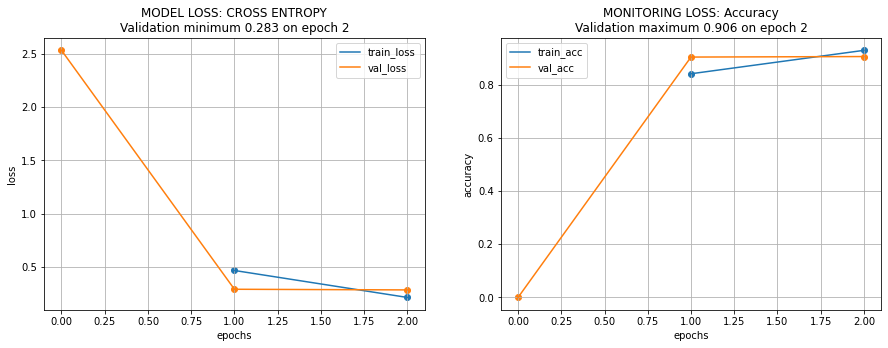

In [12]:
trainer.fit(model_resnet18, dataloader)

In [13]:
torch.save(model_resnet18.state_dict(), 'cifar10_model_70prc_freeze.pth')

В результате обучения с частично замороженными градиентами нам удалось достичь значения Accuracy Score на валидации 0.906.

Теперь разморозим все градиенты и дообучим модель дополнительно на одной эпохе.

In [14]:
# размораживаем градиенты на всех слоях
model_resnet18.unfreeze_all()

# Сбрасываем статистику обучения для графика
model_resnet18.init_train_stats()

dataloader = CIFAR10DataLoader(**config['dataloader'])
config['trainer']['max_epochs'] = 1
trainer = pl.Trainer(**config['trainer'])

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


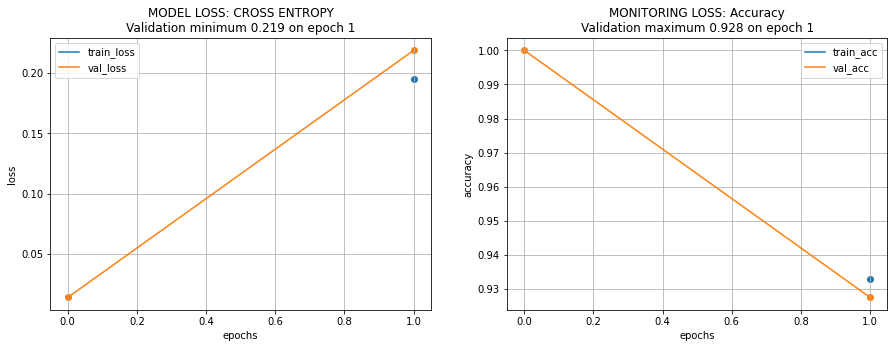

In [15]:
trainer.fit(model_resnet18, dataloader)

На нулевой эпохе pytorch lighting делает быструю валидацию на небольшой части датасета, поэтому видим значение accuracy, близкое к 1. При этом на первой эпохе мы видим значение accuracy на валидации между 0.93 и 0.92. Это значение лучше, чем предыдущее 0.906.

In [16]:
torch.save(model_resnet18.state_dict(), 'cifar10_model_unfreeze.pth')

#### 2.2.2 Дообучение модели на датасете ImageNette

Теперь вернем для модели полносвязный слой для датасета ImageNet и проверим Accuracy Score.

In [17]:
# Устанавливаем полносвязный слой для ImageNet
# !!! После выполнения метода set_fc_imagenet в оптимизатор 
# !!! будут передаваться только параметры полносвязного слоя
model_resnet18.set_fc_imagenet()

# Переводим модель в режим валидации
model_resnet18.eval()

model_accuracy = check_model_accuracy(model_resnet18, imagenette_val_dataloader)
print('Accuracy Score', model_accuracy)

  0%|          | 0/123 [00:00<?, ?it/s]

Accuracy Score 0.0007621951219512195


В результате модель разучилась предсказывать данные на ImageNette, получили значение accuracy на валидации всего 0.00076.

Чтобы это исправить и попробовать увидеть проблему "катастрофического забывания", дообучим у модели только полносвязный слой на датасете ImageNette. Полносвязный слой берем от исходной предзагруженной модели.

Дообучим модель в течении 3 эпох на датасете ImageNette

In [18]:
config = {'seed': SEED,
          'model': {
              'plot_epoch_loss': True,
              'learning_rate': 0.0001, 
              'l2_regularization': 0.01,
              'adam_betas': (0.99, 0.999),
              'pretrained': False,
              'seed': SEED,
          },
          'dataloader': {
              'imagenette_path': IMAGENETTE_DIR,
              'seed': SEED,
              'train_loader_params': {
                    'batch_size': 16,
                    'shuffle': True,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': True,
              },
              'val_loader_params': {
                    'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': False
              }
          },
         'trainer': {
              'max_epochs': 3,
              'gpus': 1 if torch.cuda.is_available() else 0,
              'progress_bar_refresh_rate': 10,
              'resume_from_checkpoint': None,
          },
}

In [19]:
# Замораживаем градиенты на всех слоях до fc не включительно
model_resnet18.freeze_layers('fc')

# Сбрасываем статистику обучения для графика
model_resnet18.init_train_stats()

trainer = pl.Trainer(**config['trainer'])
dataloader = ImageNetteDataLoader(**config['dataloader'])

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


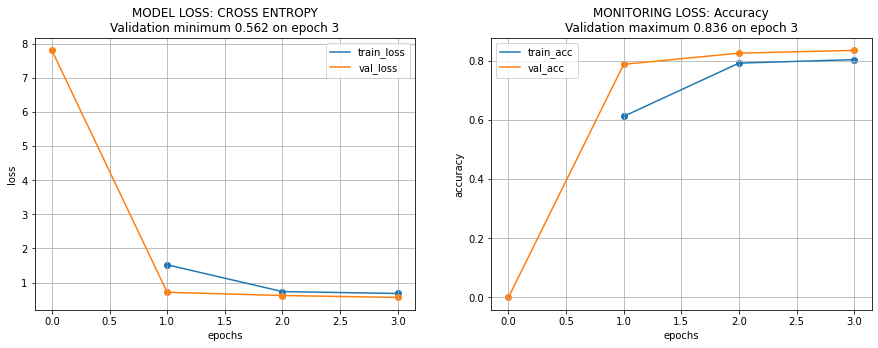

In [20]:
trainer.fit(model_resnet18, dataloader)

In [21]:
torch.save(model_resnet18.state_dict(), 'imagenette_model.pth')

После 3 эпох дообучения с градиентами только на полносвязном слое, мы смогли добиться лучшего результата: 0.836 против 0.748.

Проверим, что у нас нет ошибки. Перед дообучением модели на ImageNette мы сохранили веса модели в файл cifar10_model.pth. А после дообучения на ImageNette сохранили веса в файл imagenette_model.pth. Загрузим обе модели и сравним значения весов без полносвязного слоя. Если они совпадают, то у нас ошибки нет.

In [22]:
model_cifar10 = CIFAR10Model(**config['model'])
model_cifar10.load_state_dict(torch.load('cifar10_model_unfreeze.pth'))

model_imagenette = CIFAR10Model(**config['model'])
model_imagenette.set_fc_imagenet()
model_imagenette.load_state_dict(torch.load('imagenette_model.pth'))

params_allclose_list = []
for (name1, p1), (name1, p2) in zip(model_imagenette._model.named_parameters(), model_cifar10._model.named_parameters()):
    if 'fc' in name1:
        break
    params_allclose_list.append(np.allclose(p1.detach().numpy(), p2.detach().numpy()))
    
assert all(params_allclose_list) == True
assert model_imagenette._model.fc.out_features == 1000
assert model_cifar10._model.fc.out_features == 10

Ошибки не произошло, поэтому считаем, что ошибок в эксперименте нет и с "катастрофическим забыванием" в данной ситуации столкнуться не удалось.

А теперь попробуем дообучить модель на ImageNette, которая обучалась с частичной заморозкой. Если в этом случае мы получим результаты лучше, то мы сможем доказать существование "катастрофического забывания"

In [23]:
# Инициализируем модель
model_cifar10 = CIFAR10Model(**config['model'])

# Загружаем веса до обучения на датасете CIFAR10 с полной разморозкой
model_cifar10.load_state_dict(torch.load('cifar10_model_70prc_freeze.pth'))

# Меняем полносвязный слой от модели ImageNette
model_cifar10.set_fc_imagenet()

# Замораживаем градиенты на всех слоях до fc не включительно
model_cifar10.freeze_layers('fc')

# Сбрасываем статистику обучения для графика
model_cifar10.init_train_stats()

trainer = pl.Trainer(**config['trainer'])
dataloader = ImageNetteDataLoader(**config['dataloader'])

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


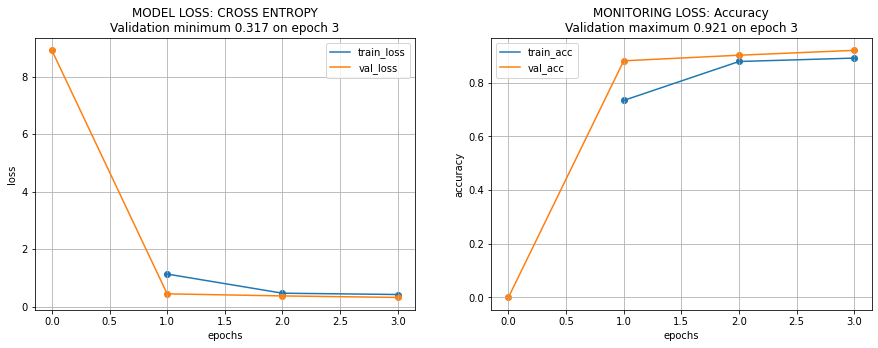

In [24]:
trainer.fit(model_cifar10, dataloader)

В результате при обучении модели на ImageNette, у которой градиенты не размораживались полностью, мы получили более лучшие результаты, чем с моделью после полной разморозки: 0.921 против 0.836.

Хотя обе дообученные модели показали более лучший результат, чем изначальная модель, разница в их качестве показывает наличие проблемы "катастрофического забывания". Модель, которая обучалась после полной разморозки, показала более худшие результаты и забыла часть исходных данных.

## Результаты

В домашней работе провели эксперимент и смогли показать наличие проблемы "катастрофического забывания".